# Preparing the data for predictive analysis

In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split
from scipy import stats
from keys import conn_str

In [2]:
df = pd.read_sql_table('pre_process', conn_str)
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13493 entries, 0 to 13492
Data columns (total 39 columns):
 #   Column                   Non-Null Count  Dtype         
---  ------                   --------------  -----         
 0   Created                  13493 non-null  datetime64[ns]
 1   index                    13493 non-null  int64         
 2   Number                   13493 non-null  object        
 3   Date                     13493 non-null  object        
 4   Gross                    13493 non-null  float64       
 5   InvoiceID                13493 non-null  object        
 6   PointsEarned             13493 non-null  float64       
 7   Variants.NettPrice       13493 non-null  float64       
 8   Variants.DiscountAmount  13493 non-null  float64       
 9   Variants.Discount        13493 non-null  float64       
 10  Variants.PriceOriginal   13493 non-null  float64       
 11  Variants.Price           13493 non-null  float64       
 12  Variants.Cost            13493 n

In [3]:
# finding the interval between item purchases in minutes

df['ItemTimeDiff'] = np.abs(df['Created'].diff(-1).dt.total_seconds().div(60).round())
df['ItemTimeDiff']

0         1.0
1         1.0
2        12.0
3         0.0
4        16.0
         ... 
13488     0.0
13489    11.0
13490    91.0
13491     0.0
13492     NaN
Name: ItemTimeDiff, Length: 13493, dtype: float64

In [4]:
df.drop(['Count' ,'Payments.Date', 'PointsEarned', 'Date', 'Variants.Code', 'Payments.Note', 'Payments.Code',
         'Variants.PriceOriginal', 'Gross'], axis=1, inplace=True)

In [5]:
df.isnull().sum()

Created                    0
index                      0
Number                     0
InvoiceID                  0
Variants.NettPrice         0
Variants.DiscountAmount    0
Variants.Discount          0
Variants.Price             0
Variants.Cost              0
Variants.Quantity          0
Variants.Name              0
Payments.Method            0
Payments.Amount            0
year                       0
month                      0
day                        0
dayOfWeek                  0
weekOfMonth                0
hour                       0
minute                     0
LastPurchaseDate           0
Recency                    0
Frequency                  0
LastPurYear                0
LastPurMonth               0
LastPurDay                 0
weekDayOfLastPur           0
yearWeekOfLastPur          0
LastPurHour                0
LastPurMinute              0
ItemTimeDiff               1
dtype: int64

In [6]:
df = df.rename(columns=
               {"Payments.Amount": "PaidAmount",
                "Payments.Method": "PaymentMethod",
                "Variants.Cost": "UnitCost",
                "Variants.Discount": "ProductDiscount",
                "Variants.DiscountAmount": "ProductDiscountAmount",
                "Variants.Name": "product",
                "Variants.NettPrice": "TotalPrice",
                "Variants.Price": "UnitPrice",
                "Variants.Quantity": "Quantity",
                "day": "Day",
                "hour": "Hour",
                "minute": "Minute",
                "month": "Month",
                "year": "Year",
                "Number": "number",
                "Created": "created",
                "InvoiceID": "invoiceid",
                "dayOfWeek": "DayOfWeek",
                "weekOfMonth": "WeekOfMonth",
                "LastPurchaseDate": "lastPurchaseDate",
                "weekDayOfLastPur": "WeekDayOfLastPur",
                "yearWeekOfLastPur": "WeekOfLastPur"
                })
df.head()

,created,index,number,invoiceid,TotalPrice,ProductDiscountAmount,ProductDiscount,UnitPrice,UnitCost,Quantity,...,Recency,Frequency,LastPurYear,LastPurMonth,LastPurDay,WeekDayOfLastPur,WeekOfLastPur,LastPurHour,LastPurMinute,ItemTimeDiff
0,2020-02-07 22:51:30.473,0,20.02.002,a4f938d7-a234-49f9-9588-ea6dc1b547b2,200.0,0.0,0.0,200.0,0.0,1.0,...,240,87,2020,5,30,5,22,18,36,1.0
1,2020-02-07 22:52:50.140,1,20.02.003,89681b1f-21ab-4f0a-8780-3971de3f82b0,400.0,0.0,0.0,200.0,120.0,2.0,...,84,14,2020,11,2,0,45,21,13,1.0
2,2020-02-07 22:53:26.450,2,20.02.004,af594745-e964-4051-ae17-93b23b746743,100.0,0.0,0.0,100.0,75.0,1.0,...,127,130,2020,9,20,6,38,20,37,12.0
3,2020-02-07 23:05:02.100,3,20.02.005,a76090aa-9470-4ef5-8e38-59568d23bdae,300.0,0.0,0.0,300.0,183.0,1.0,...,76,56,2020,11,10,1,46,20,26,0.0
4,2020-02-07 23:05:02.100,3,20.02.005,a76090aa-9470-4ef5-8e38-59568d23bdae,80.0,0.0,0.0,80.0,0.0,1.0,...,343,11,2020,2,17,0,8,18,14,16.0


In [7]:
df['GrossMargin'] = df['UnitPrice'] - df['UnitCost']
df['ProfitLoss'] = np.where(df.GrossMargin<0, "Loss", "Profit")
df['MarginPerc'] = df.GrossMargin / df.UnitCost
df.replace([np.inf, -np.inf], 1, inplace=True)
df['MarginDeviation'] = 1 - df.MarginPerc
df['DeviationType'] = np.where(df.MarginDeviation<0, "Positive", "Negative")
df.head()

,created,index,number,invoiceid,TotalPrice,ProductDiscountAmount,ProductDiscount,UnitPrice,UnitCost,Quantity,...,WeekDayOfLastPur,WeekOfLastPur,LastPurHour,LastPurMinute,ItemTimeDiff,GrossMargin,ProfitLoss,MarginPerc,MarginDeviation,DeviationType
0,2020-02-07 22:51:30.473,0,20.02.002,a4f938d7-a234-49f9-9588-ea6dc1b547b2,200.0,0.0,0.0,200.0,0.0,1.0,...,5,22,18,36,1.0,200.0,Profit,1.000000,0.000000,Negative
1,2020-02-07 22:52:50.140,1,20.02.003,89681b1f-21ab-4f0a-8780-3971de3f82b0,400.0,0.0,0.0,200.0,120.0,2.0,...,0,45,21,13,1.0,80.0,Profit,0.666667,0.333333,Negative
2,2020-02-07 22:53:26.450,2,20.02.004,af594745-e964-4051-ae17-93b23b746743,100.0,0.0,0.0,100.0,75.0,1.0,...,6,38,20,37,12.0,25.0,Profit,0.333333,0.666667,Negative
3,2020-02-07 23:05:02.100,3,20.02.005,a76090aa-9470-4ef5-8e38-59568d23bdae,300.0,0.0,0.0,300.0,183.0,1.0,...,1,46,20,26,0.0,117.0,Profit,0.639344,0.360656,Negative
4,2020-02-07 23:05:02.100,3,20.02.005,a76090aa-9470-4ef5-8e38-59568d23bdae,80.0,0.0,0.0,80.0,0.0,1.0,...,0,8,18,14,16.0,80.0,Profit,1.000000,0.000000,Negative


In [8]:
df = df.reindex(sorted(df.columns), axis=1)
df

,Day,DayOfWeek,DeviationType,Frequency,GrossMargin,Hour,ItemTimeDiff,LastPurDay,LastPurHour,LastPurMinute,...,WeekDayOfLastPur,WeekOfLastPur,WeekOfMonth,Year,created,index,invoiceid,lastPurchaseDate,number,product
0,7,4,Negative,87,200.0,22,1.0,30,18,36,...,5,22,6,2020,2020-02-07 22:51:30.473,0,a4f938d7-a234-49f9-9588-ea6dc1b547b2,2020-05-30 18:36:43.857,20.02.002,Ladies Dress 200bob 2001
1,7,4,Negative,14,80.0,22,1.0,2,21,13,...,0,45,6,2020,2020-02-07 22:52:50.140,1,89681b1f-21ab-4f0a-8780-3971de3f82b0,2020-11-02 21:13:17.210,20.02.003,Men Trousers
2,7,4,Negative,130,25.0,22,12.0,20,20,37,...,6,38,6,2020,2020-02-07 22:53:26.450,2,af594745-e964-4051-ae17-93b23b746743,2020-09-20 20:37:31.790,20.02.004,Men tshirts
3,7,4,Negative,56,117.0,23,0.0,10,20,26,...,1,46,6,2020,2020-02-07 23:05:02.100,3,a76090aa-9470-4ef5-8e38-59568d23bdae,2020-11-10 20:26:25.740,20.02.005,Lady Hand bag
4,7,4,Negative,11,80.0,23,16.0,17,18,14,...,0,8,6,2020,2020-02-07 23:05:02.100,3,a76090aa-9470-4ef5-8e38-59568d23bdae,2020-02-17 18:14:30.623,20.02.005,Children Jackets 80bob 3003
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
13488,25,0,Positive,136,33.0,22,0.0,25,22,22,...,0,4,4,2021,2021-01-25 22:22:41.243,2750,746f97a4-947b-497b-830f-dd1d1c05394b,2021-01-25 22:22:41.243,21.01.513,Cotton Tops
13489,25,0,Negative,94,-24.0,22,11.0,26,0,4,...,1,4,4,2021,2021-01-25 22:22:41.243,2750,746f97a4-947b-497b-830f-dd1d1c05394b,2021-01-26 00:04:36.673,21.01.513,Velvet 4
13490,25,0,Negative,43,-50.0,22,91.0,26,0,4,...,1,4,4,2021,2021-01-25 22:33:50.673,2751,7a2899db-2d87-46bc-a9c4-565d08df0d0d,2021-01-26 00:04:36.673,21.01.514,pallazo pants 5
13491,26,1,Negative,94,-24.0,0,0.0,26,0,4,...,1,4,4,2021,2021-01-26 00:04:36.673,2752,5f82a83d-5547-4d20-9b5f-54f1d3b77493,2021-01-26 00:04:36.673,21.01.515,Velvet 4


In [9]:
df.drop(['created', 'index', 'invoiceid', 'lastPurchaseDate'], inplace=True, axis=1)

### Categorical Variables

In [10]:
categorical = [var for var in df.columns if df[var].dtype=="O"]
print("{} categorical variables".format(len(categorical)))

5 categorical variables


### Numerical Variables

In [11]:
numerical = [var for var in df.columns if df[var].dtype!="O"]
print("{} numerical variables".format(len(numerical)))

27 numerical variables


### Temporal Variables

In [12]:
year_vars = [var for var in numerical if "Year" in var]
df[year_vars].head()

,LastPurYear,Year
0,2020,2020
1,2020,2020
2,2020,2020
3,2020,2020
4,2020,2020


### Finding discrete numerical values

In [13]:
discrete = []

for var in numerical:
    if len(df[var].unique())<60 and var not in year_vars:
        print(var, 'values: ', df[var].unique())
        discrete.append(var)

print('{} discrete variables'.format(len(discrete)))

Day values:  [ 7  8  9 13 16 10 11 12 14 15 17 18 19 20 21 22 23 24 27 25 26 29 28  1
  2  4  3  5  6 30 31]
DayOfWeek values:  [4 5 6 3 0 1 2]
Hour values:  [22 23  0 18 19 20 21 15 16 17  1 14 13]
LastPurDay values:  [30  2 20 10 17  4  3  9 16 18 15 31 24 21  8 29  6 13 14 11 28 19  5 22
  1 12 27  7 25 23 26]
LastPurHour values:  [18 21 20 17 23 19 22 15 16  1  0 14]
LastPurMinute values:  [36 13 37 26 14 17 34 11  3 45 57  2 43  8 16 25 21 18 49  0 23  4 15 24
 58 48 19 41 20 54 29  1  5 40 28 47 10 51 27  9 44 50 52 59 42  6 56 39
 31  7 32 53 38 22 12 33 55 46 35]
LastPurMonth values:  [ 5 11  9  2  6  3  8 10  7  4 12  1]
Month values:  [ 2  3  4  5  6  7  8  1 10  9 11 12]
ProductDiscount values:  [ 0. 20. 15. 10. 25.]
ProductDiscountAmount values:  [ 0. 50. 30. 60. 20.  5. 40.]
Quantity values:  [ 1.  2.  3. -1.  4.  6.  7.  5. -2.  8. 14. 19. 11. -3. -4. 10.  9. 17.
 13. 16. 15. 12. 18. 40. 55. 42. 25. 32. 28. 46. 37.]
WeekDayOfLastPur values:  [5 0 6 1 3 2 4]
WeekOfLastPur 

### Finding continuous numerical values

In [14]:
numerical = [var for var in numerical if var not in discrete and var not in year_vars and var not in ['Minute']]
print(numerical)

['Frequency', 'GrossMargin', 'ItemTimeDiff', 'MarginDeviation', 'MarginPerc', 'PaidAmount', 'Recency', 'TotalPrice', 'UnitCost', 'UnitPrice']


## Checking for missing values

In [15]:
vars_with_na = [var for var in df.columns if df[var].isnull().sum()>0]
print("Variables with missing information: ", len(vars_with_na))

Variables with missing information:  1


In [16]:
#visualisation of missing values per variable
for var in df.columns:
    if df[var].isnull().sum():
        print(var, df[var].isnull().mean())

ItemTimeDiff 7.411250277921885e-05


In [28]:
df['ItemTimeDiff'].fillna(value=0.0, inplace=True)
df.ItemTimeDiff.tail()

13488     0.0
13489    11.0
13490    91.0
13491     0.0
13492     0.0
Name: ItemTimeDiff, dtype: float64

In [27]:
# this code inspects the variables types with missing values
for var in df.columns:
    if df[var].isnull().mean()>0.80:
        print(var, df[var].unique())

## Outlier Detection

In [18]:
numerical

['Frequency',
 'GrossMargin',
 'ItemTimeDiff',
 'MarginDeviation',
 'MarginPerc',
 'PaidAmount',
 'Recency',
 'TotalPrice',
 'UnitCost',
 'UnitPrice']

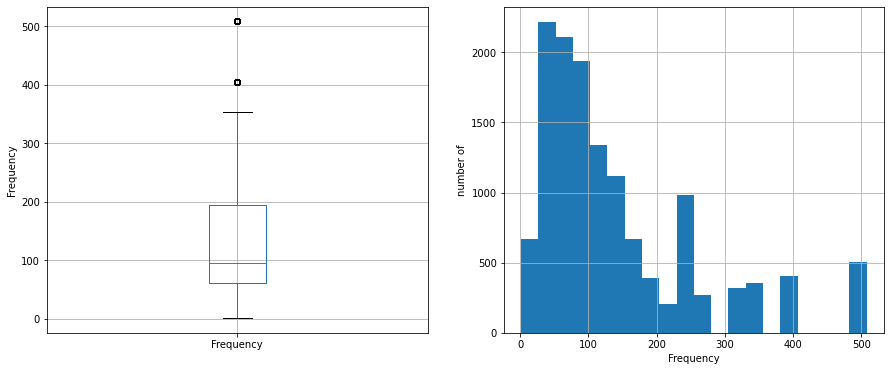

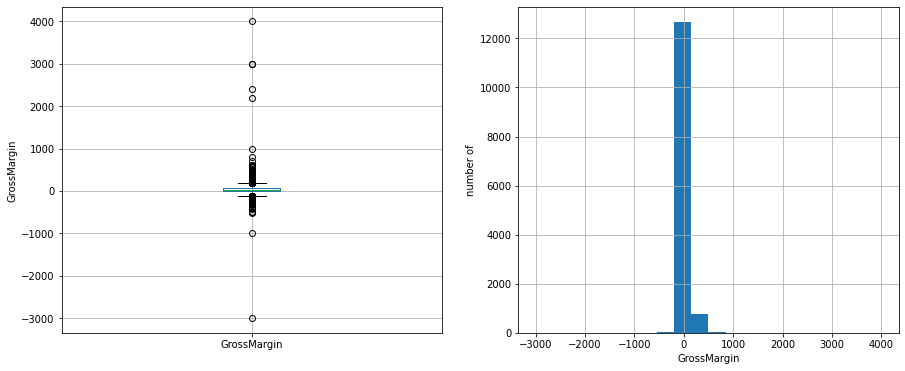

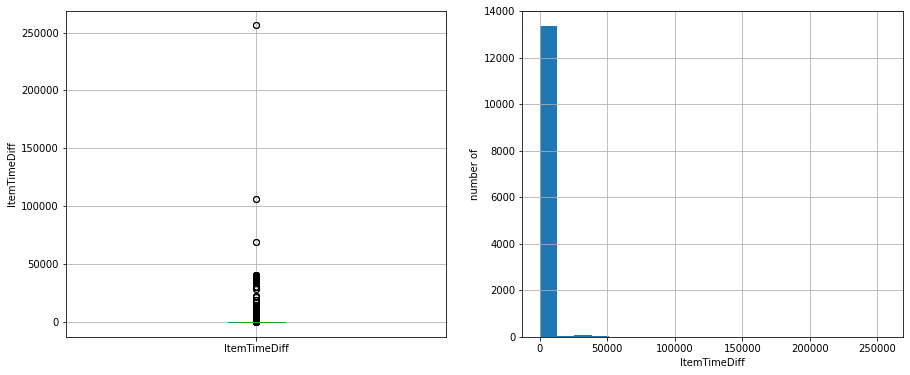

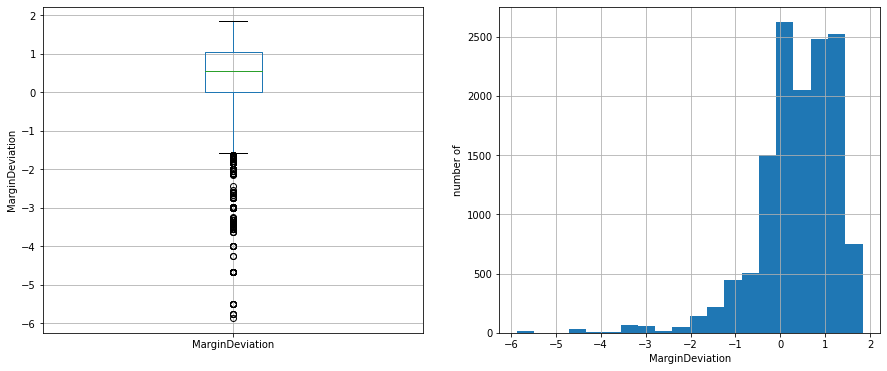

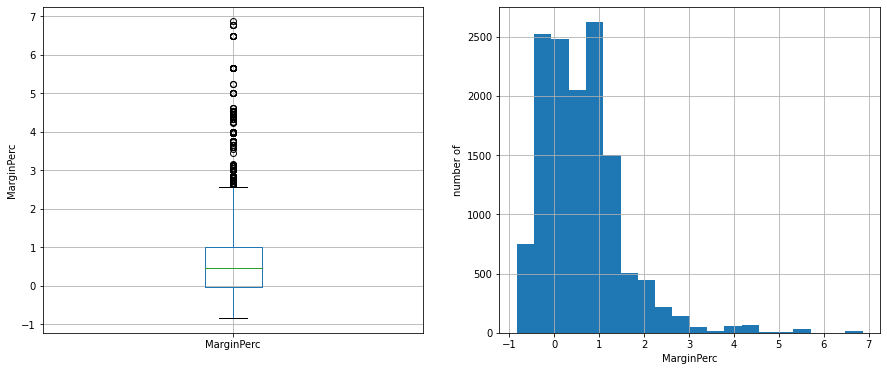

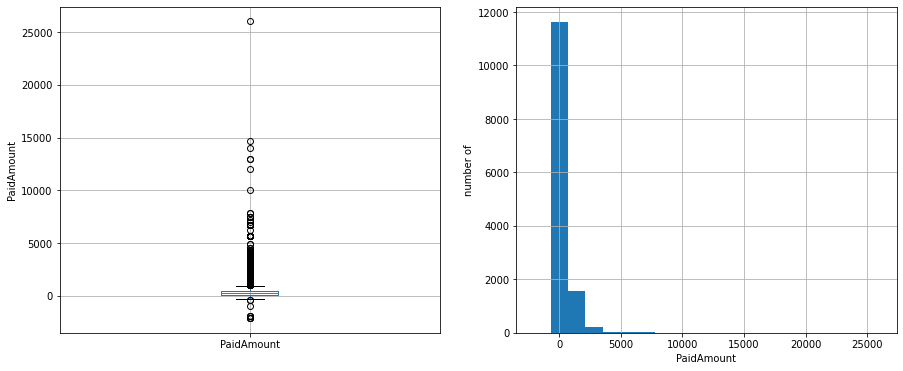

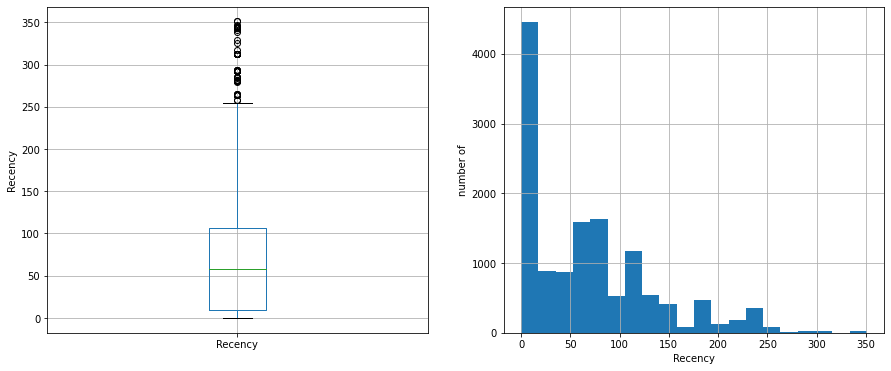

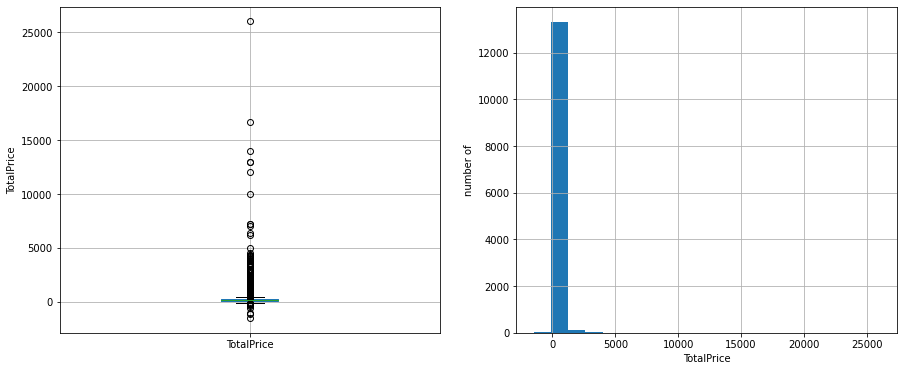

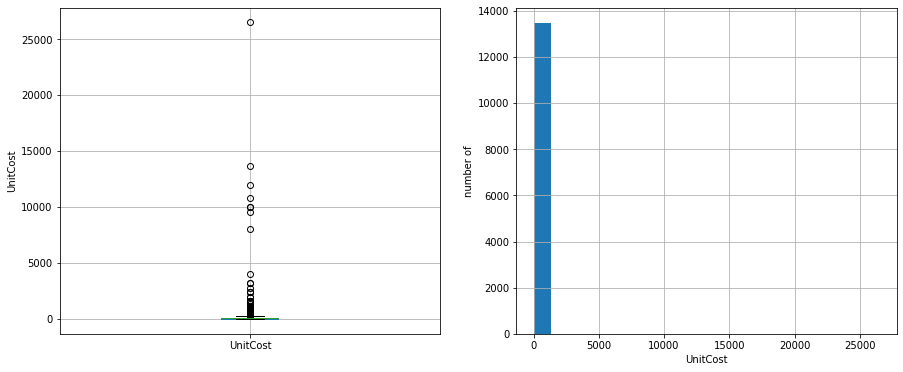

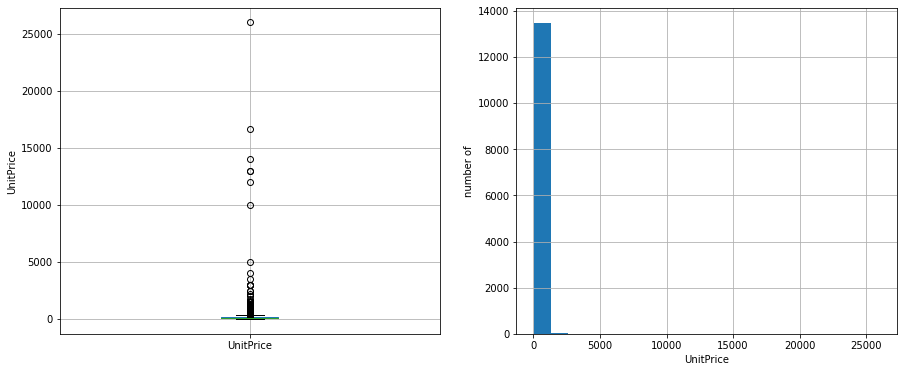

In [19]:
for var in numerical:
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    fig = df.boxplot(column=var)
    fig.set_title('')
    fig.set_ylabel(var)

    plt.subplot(1, 2, 2)
    fig = df[var].hist(bins=20)
    fig.set_ylabel('number of')
    fig.set_xlabel(var)

    plt.show()

## Cardinality check

Text(0, 0.5, 'Number of different categories')

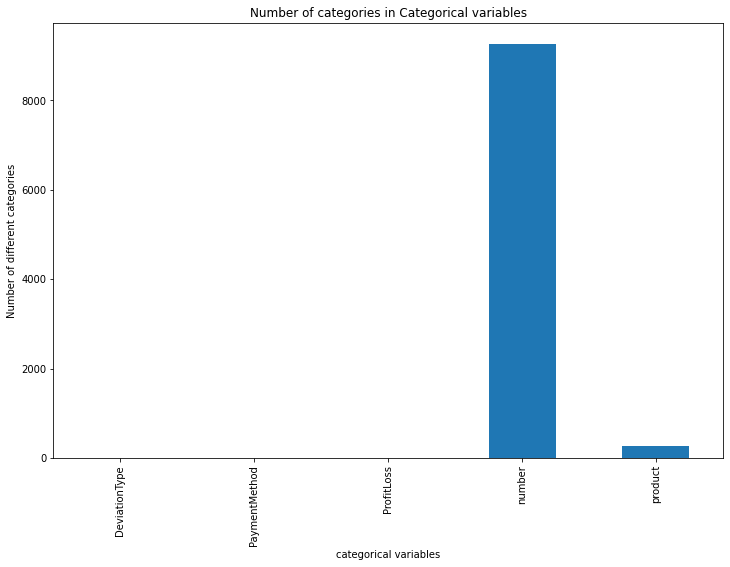

In [20]:
no_labels_ls = []
for var in categorical:
    no_labels_ls.append(df[var].nunique())

tmp = pd.Series(no_labels_ls)
tmp.index = pd.Series(categorical)
tmp.plot.bar(figsize=(12,8))
plt.title('Number of categories in Categorical variables')
plt.xlabel('categorical variables')
plt.ylabel('Number of different categories')

## Train / Test Splitting

Splitting the data to train and test

In [21]:
X_train, X_test, y_train, y_test = train_test_split(df, df.TotalPrice, test_size=0.2, random_state=0)
X_train.shape, X_test.shape

((10794, 32), (2699, 32))

In [32]:
# removing the Year columns from train/test data

X_train.drop(columns=['Year', 'LastPurYear'], axis=1, inplace=True)
X_test.drop(columns=['Year', 'LastPurYear'], axis=1, inplace=True)

/Users/erickamau/PycharmProjects/ADS/venv/lib/python3.8/site-packages/pandas/core/frame.py:4163: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  return super().drop(


In [34]:
def elapsed_months(df, var):
    df[var] = df['Month'] - df[var]
    return df

In [35]:
for var in ['LastPurMonth']:
    X_train = elapsed_months(X_train, var)
    X_test = elapsed_months(X_test, var)

X_train['LastPurMonth'].head()

<ipython-input-34-f7e89d348b2b>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df[var] = df['Month'] - df[var]


8516     9
11022   -1
1830    -4
1498    -3
2442     5
Name: LastPurMonth, dtype: int64